# 11785 Fall 2024 Project
#Group XV

In [38]:
# install libraries
!pip install torch torchmetrics --q
!pip install wandb --quiet
!pip install pytorch-msssim --q
!pip install adabelief-pytorch --q

!pip install torchsummary -q


# Import Libraries

In [39]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
# from torchvision.utils import make_grid
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

import random
from sklearn.model_selection import train_test_split
from pytorch_msssim import ssim

# from torchmetrics.functional import structural_similarity_index_measure as ssim
from adabelief_pytorch import AdaBelief


In [40]:
!nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Tue Nov 26 12:39:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              30W /  70W |   1027MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataset


In [41]:
# # unzip dataset
# !unzip -q /content/ProstateCancerDataset.zip
# !ls

# Config

In [59]:
# configs
config ={
    "dataset_dir" : '/content/ProstateCancerDataset',
    "output_dir" : '/content/output_bgan',
    "epochs" : 300,
    "lr": 0.001,
    "batch_size" : 2,  # BicycleGAN typically uses batch size of 1
    "num_workers" : 2,
    "random_seed": 0,
    "max_grad_norm": 0.1,
    "img_size": 256,
    "lambda_L1": 10,        # Weight for L1 loss, start with 10 and adjust based on image sharpness
    "lambda_KL": 0.005,      # Weight for KL divergence, start with 0.01 and adjust based on latent space regularization
    "latent_dim": 32       # Dimension of the latent vector, adjust based on desired diversity and complexity

    }

# Data Loading

In [43]:

class MRIDataset(Dataset):
    def __init__(self, dataset_dir, transform=None, img_size=256):
        self.root_dir = dataset_dir
        self.transform = transform
        self.img_size = img_size
        # create resize transform
        self.resize = transforms.Compose([
            transforms.Resize((img_size, img_size), antialias=True),
        ])

        # collect all slices
        self.slices = []

        # Scan directories
        adc_dir = os.path.join(dataset_dir, "ADC")
        for patient_dir in sorted(os.listdir(adc_dir)):
            patient_adc_dir = os.path.join(adc_dir, patient_dir)
            patient_t2w_dir = os.path.join(dataset_dir, "T2w_Type",
                                         patient_dir.replace('_adc', '_t2w'))

            if os.path.exists(patient_t2w_dir):
                adc_files = sorted([f for f in os.listdir(patient_adc_dir)
                                  if os.path.isfile(os.path.join(patient_adc_dir, f))])
                t2w_files = sorted([f for f in os.listdir(patient_t2w_dir)
                                  if os.path.isfile(os.path.join(patient_t2w_dir, f))])

                min_slices = min(len(adc_files), len(t2w_files))

                for i in range(min_slices):
                    self.slices.append({
                        'adc_path': os.path.join(patient_adc_dir, adc_files[i]),
                        't2w_path': os.path.join(patient_t2w_dir, t2w_files[i])
                    })

    def __getitem__(self, idx):
        slice_paths = self.slices[idx]

        # load images
        adc_image = Image.open(slice_paths['adc_path']).convert('L')
        t2w_image = Image.open(slice_paths['t2w_path']).convert('L')

        # resize images
        adc_image = self.resize(adc_image)
        t2w_image = self.resize(t2w_image)

        # apply other transforms
        if self.transform:
            adc_image = self.transform(adc_image)
            t2w_image = self.transform(t2w_image)

        return {
            'A': adc_image,  # source domain (ADC)
            'B': t2w_image   # target domain (T2w)
        }


    def __len__(self):
        return len(self.slices)



In [44]:
def create_data_loaders(config):
    """
    Create train, validation, and test data loaders
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create full dataset
    full_dataset = MRIDataset(dataset_dir=config['dataset_dir'], transform=transform)

    # Calculate lengths for splits
    total_size = len(full_dataset)
    train_size = int(0.78 * total_size)
    val_size = int(0.12 * total_size)
    test_size = total_size - train_size - val_size

    # Create splits
    train_indices, temp_indices = train_test_split(
        range(total_size), test_size=(val_size + test_size),
        random_state=config['random_seed']
    )
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=test_size,
        random_state=config['random_seed']
    )

    # Create subset datasets based on split ratios
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    print(f"Total slices: {total_size}")
    print(f"Training slices: {len(train_dataset)}")
    print(f"Validation slices: {len(val_dataset)}")
    print(f"Testing slices: {len(test_dataset)}")

    return train_loader, val_loader, test_loader



In [45]:
# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(config)

Total slices: 304
Training slices: 237
Validation slices: 36
Testing slices: 31


# Model

## Encoder

In [46]:

class Encoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()

        # Input: B x 1 x 256 x 256 (image size)

        self.model = nn.Sequential(
            # Initial layer
            nn.Conv2d(1, 64, 4, stride=2, padding=1),  # B x 64 x 128 x 128
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            # Downsampling layers
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # B x 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # B x 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # B x 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),  # B x 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 4, stride=2, padding=1),  # B x 512 x 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),
        )

        # Output mu and logvar for the latent space
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        features = self.model(x)
        features = features.view(features.size(0), -1)

        mu = self.fc_mu(features)
        logvar = self.fc_logvar(features)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

## Generator

In [47]:
class Generator(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()

        # Initial processing of source image
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),  # B x 64 x 128 x 128
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),
            nn.Dropout(0.25)
        )

        # Downsample blocks
        self.down_blocks = nn.ModuleList([
            self._make_down_block(64, 128),    # B x 128 x 64 x 64
            self._make_down_block(128, 256),   # B x 256 x 32 x 32
            self._make_down_block(256, 512),   # B x 512 x 16 x 16
            self._make_down_block(512, 512),   # B x 512 x 8 x 8
            self._make_down_block(512, 512),   # B x 512 x 4 x 4
        ])

        # Inject latent code
        self.latent_projection = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.ReLU(True),
            # nn.GELU()
        )

        # Upsample blocks
        self.up_blocks = nn.ModuleList([
            self._make_up_block(1024, 512),    # B x 512 x 8 x 8
            self._make_up_block(1024, 512),    # B x 512 x 16 x 16
            self._make_up_block(1024, 256),    # B x 256 x 32 x 32
            self._make_up_block(512, 128),     # B x 128 x 64 x 64
            self._make_up_block(256, 64),      # B x 64 x 128 x 128
        ])

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),  # B x 1 x 256 x 256
            nn.Tanh()
        )

    def _make_down_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True)
        )

    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
            # nn.GELU()
        )

    def forward(self, x, z):
        # Process input image through downsample blocks
        features = [self.conv1(x)]
        for block in self.down_blocks:
            features.append(block(features[-1]))

        # Process latent code
        z = self.latent_projection(z)
        z = z.view(z.size(0), -1, 4, 4)

        # Combine with last feature map
        x = torch.cat([features[-1], z], dim=1)

        # Upsample with skip connections
        for i, block in enumerate(self.up_blocks):
            x = block(x)
            if i < len(features) - 1:  # Skip connection
                x = torch.cat([x, features[-(i+2)]], dim=1)

        # Final output
        return self.final(x)

## Discriminator

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # Process paired images (source + target)
        self.model = nn.Sequential(
            # Input: B x 2 x 256 x 256 (concatenated source and target images)
            nn.Conv2d(2, 64, 4, stride=2, padding=1),  # B x 64 x 128 x 128
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # B x 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),


            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # B x 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # B x 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, True),
            # nn.GELU(),
            # nn.ReLU(inplace=True),

            nn.Conv2d(512, 1, 4, stride=1, padding=1),  # B x 1 x 15 x 15
        )

    def forward(self, source, target):
        # Concatenate source and target images along channel dimension
        x = torch.cat([source, target], dim=1)
        return self.model(x)



## Bicycle GAN

In [49]:
# class that manages all models (E, G, D) and their interactions
class BicycleGAN:
    def __init__(self, lr=config['lr'], input_size=256, beta1=0.5):
        self.latent_dim = config['latent_dim']
        self.input_size = input_size
        self.lambda_L1 = config['lambda_L1']
        self.lambda_KL = config['lambda_KL']
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize networks with correct input size
        self.E = Encoder(latent_dim=config['latent_dim']).to(self.device)
        self.G = Generator(latent_dim=config['latent_dim']).to(self.device)
        self.D = Discriminator().to(self.device)

        # Initialize weights
        self.E.apply(self.weights_init)
        self.G.apply(self.weights_init)
        self.D.apply(self.weights_init)

        # Optimizers with reduced learning rate and beta values
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(beta1, 0.999))
        self.opt_E = torch.optim.Adam(self.E.parameters(), lr=lr, betas=(beta1, 0.999))
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(beta1, 0.999))

        # self.opt_G = torch.optim.SGD(
        #     self.G.parameters(),
        #     lr=lr,
        #     momentum=0.9,  # Momentum helps with faster convergence
        #     nesterov=True
        # )

        # # SGD with Nesterov momentum
        # self.opt_E = torch.optim.SGD(
        #     self.E.parameters(),
        #     lr=lr,
        #     momentum=0.9,
        #     nesterov=True  # Often provides better convergence than standard momentum
        # )

        # # SGD with weight decay (L2 regularization)
        # self.opt_D = torch.optim.SGD(
        #     self.D.parameters(),
        #     lr=lr,
        #     momentum=0.9,
        #     weight_decay=0.0001
        # )

        self.opt_G = AdaBelief(
            self.G.parameters(),
            lr=lr,
            betas=(beta1, 0.999),
            eps=1e-16,
            weight_decay=0.01,
            weight_decouple=True,
            rectify=False
        )

        self.opt_E = AdaBelief(
            self.E.parameters(),
            lr=lr,
            betas=(beta1, 0.999),
            eps=1e-16,
            weight_decay=0.01,
            weight_decouple=True,
            rectify=False
        )

        self.opt_D = AdaBelief(
            self.D.parameters(),
            lr=lr,
            betas=(beta1, 0.999),
            eps=1e-16,
            weight_decay=0.01,
            weight_decouple=True,
            rectify=False
        )


        # Initialize schedulers
        self.scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt_G,
            mode='min',
            factor=0.8,
            patience=12,
            verbose=True,
            min_lr=1e-7
        )

        self.scheduler_E = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt_E,
            mode='min',
            factor=0.8,
            patience=12,
            verbose=True,
            min_lr=1e-7
        )

        self.scheduler_D = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt_D,
            mode='min',
            factor=0.8,
            patience=12,
            verbose=True,
            min_lr=1e-7
        )

        self.criterion_GAN = nn.MSELoss()
        self.criterion_L1 = nn.L1Loss()
        self.criterion_KL = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    @staticmethod
    def weights_init(m):
        """Initialize network weights."""
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def train_step(self, source, target, lambda_L1=10, lambda_KL=0.01):
        """Single training step"""
        # Add gradient clipping value
        max_grad_norm = config['max_grad_norm']

        real_label = torch.ones((source.size(0), 1, 15, 15)).to(self.device)
        fake_label = torch.zeros((source.size(0), 1, 15, 15)).to(self.device)

        # Forward cycle (cVAE-GAN)
        self.opt_E.zero_grad()
        self.opt_G.zero_grad()

        # Get latent encoding of target image
        mu, logvar = self.E(target)
        z = self.E.reparameterize(mu, logvar)

        # Generate fake image
        fake_B = self.G(source, z)

        # Discriminator loss for generated image
        pred_fake = self.D(source, fake_B)
        loss_G_GAN = self.criterion_GAN(pred_fake, real_label) * 0.5  # Scale down GAN loss

        # L1 loss between generated and target
        loss_G_L1 = self.criterion_L1(fake_B, target) * lambda_L1

        # KL loss with scaling
        loss_KL = self.criterion_KL(mu, logvar) * lambda_KL

        # Backward cycle (cLR-GAN)
        z_random = torch.randn(source.size(0), self.latent_dim).to(self.device)
        fake_B_random = self.G(source, z_random)
        mu2, logvar2 = self.E(fake_B_random)

        # Latent regression loss
        loss_z_L1 = self.criterion_L1(mu2, z_random) * lambda_L1

        # Total generator and encoder loss
        loss_G = loss_G_GAN + loss_G_L1 + loss_KL + loss_z_L1

        # Check for NaN loss value
        if not torch.isnan(loss_G):
            loss_G.backward()
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(self.G.parameters(), max_grad_norm)
            torch.nn.utils.clip_grad_norm_(self.E.parameters(), max_grad_norm)
            self.opt_E.step()
            self.opt_G.step()

        # Discriminator update
        self.opt_D.zero_grad()

        # Real loss
        pred_real = self.D(source, target)
        loss_D_real = self.criterion_GAN(pred_real, real_label)

        # Fake loss (cVAE-GAN)
        pred_fake = self.D(source, fake_B.detach())
        loss_D_fake1 = self.criterion_GAN(pred_fake, fake_label)

        # Fake loss (cLR-GAN)
        pred_fake = self.D(source, fake_B_random.detach())
        loss_D_fake2 = self.criterion_GAN(pred_fake, fake_label)

        # Total discriminator loss
        loss_D = (loss_D_real + loss_D_fake1 + loss_D_fake2) * 0.5

        # Check for NaN
        if not torch.isnan(loss_D):
            loss_D.backward()
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(self.D.parameters(), max_grad_norm)
            self.opt_D.step()

        return {
            'G_loss': loss_G.item() if not torch.isnan(loss_G) else 0,
            'D_loss': loss_D.item() if not torch.isnan(loss_D) else 0,
            'KL': loss_KL.item() if not torch.isnan(loss_KL) else 0,
            'L1': loss_G_L1.item() if not torch.isnan(loss_G_L1) else 0,
            'z_L1': loss_z_L1.item() if not torch.isnan(loss_z_L1) else 0
        }


    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=False for networks to avoid unnecessary computations"""
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad


    def encode(self, input_image):
        mu, logvar = self.E(input_image)
        z = self.E.reparameterize(mu, logvar)
        return z, mu, logvar

    def generate(self, input_image, z):
        return self.G(input_image, z)


    def visualize_results(self, source, target, epoch, num_samples=4):
        """
        Visualize multiple generation results from the same input image
        Args:
            source: Source image (ADC)
            target: Ground truth target image (T2w)
            epoch: Current epoch number
            num_samples: Number of different results to generate
        """
        self.E.eval()
        self.G.eval()
        with torch.no_grad():
            # Generate multiple outputs using different random latent codes
            outputs = []
            for _ in range(num_samples):
                z = torch.randn(source.size(0), self.latent_dim).to(self.device)
                fake = self.G(source, z)
                outputs.append(fake)

            # Create visualization grid
            # First row: [source, target]
            # Following rows: different generated outputs
            vis_images = [source[0], target[0]]  # First row
            for out in outputs:
                vis_images.append(out[0])

            # Convert from [-1, 1] to [0, 1] range for visualization
            vis_images = [(img + 1) / 2 for img in vis_images]

            # Create grid
            image_grid = vutils.make_grid(vis_images, nrow=2, padding=2, normalize=False)

            # Plot
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(image_grid.cpu().numpy()[0], cmap='gray')
            plt.title(f'Epoch {epoch}\nTop: [Source | Target]\nBottom: Generated Samples')
            plt.show()
            plt.close()



    def visualize_interpolation(self, source, target, epoch, num_steps=5):
        """
        Visualize interpolation between two random latent codes
        """
        self.E.eval()
        self.G.eval()
        with torch.no_grad():
            # Get two random latent codes
            z1 = torch.randn(1, self.latent_dim).to(self.device)
            z2 = torch.randn(1, self.latent_dim).to(self.device)

            # Interpolate between latent codes
            alphas = torch.linspace(0, 1, num_steps)
            interpolated = []

            for alpha in alphas:
                z = alpha * z1 + (1 - alpha) * z2
                fake = self.G(source, z)
                interpolated.append(fake[0])

            # Create visualization grid
            vis_images = [source[0], target[0]] + interpolated
            vis_images = [(img + 1) / 2 for img in vis_images]

            # Create grid
            image_grid = vutils.make_grid(vis_images, nrow=len(vis_images), padding=2, normalize=False)

            # Plot
            plt.figure(figsize=(15, 5))
            plt.axis('off')
            plt.imshow(image_grid.cpu().numpy()[0], cmap='gray')
            plt.title(f'Epoch {epoch}\nLeft: [Source | Target | Interpolated Samples]')
            plt.show()
            plt.close()

    @staticmethod
    def calculate_psnr(fake, real):
        """Calculate PSNR between fake and real images"""
        mse = F.mse_loss(fake, real)
        psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))
        return psnr.item()

    @staticmethod
    def calculate_ssim(fake, real):
        """Calculate SSIM between fake and real images"""
        # Implementation of SSIM calculation
        return ssim(fake, real, data_range=2.0).item()  # 2.0 for [-1,1] range


    def visualize_batch(self, source, target, generated, title, save_path=None):
        """
        Visualize a batch of images: source, target, and generated
        Args:
            source: source images
            target: target images
            generated: list of generated images (for multiple samples)
            title: title for the plot
            save_path: if provided, save the plot to this path
        """
        # Convert tensors to PIL images
        def tensor_to_numpy(tensor):
            #  convert to [0, 1] (for tensor in [-1, 1] range)
            return ((tensor.cpu().detach() + 1) / 2.0).numpy()

        # Create figure
        num_samples = len(generated)
        fig, axes = plt.subplots(2, num_samples + 2, figsize=(3*(num_samples + 2), 6))
        plt.suptitle(title)

        # Plot source and target in first row
        axes[0, 0].imshow(tensor_to_numpy(source[0])[0], cmap='gray')
        axes[0, 0].set_title('Source (ADC)')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(tensor_to_numpy(target[0])[0], cmap='gray')
        axes[0, 1].set_title('Target (T2)')
        axes[0, 1].axis('off')

        # Plot generated samples
        for i, gen in enumerate(generated):
            axes[0, i+2].imshow(tensor_to_numpy(gen[0])[0], cmap='gray')
            axes[0, i+2].set_title(f'Generated {i+1}')
            axes[0, i+2].axis('off')

        # Plot differences in second row
        diff_target = np.abs(tensor_to_numpy(target[0])[0] - tensor_to_numpy(source[0])[0])
        axes[1, 0].imshow(diff_target, cmap='hot')
        axes[1, 0].set_title('Diff: Target-Source')
        axes[1, 0].axis('off')

        axes[1, 1].axis('off')  # Empty plot for alignment

        for i, gen in enumerate(generated):
            diff_gen = np.abs(tensor_to_numpy(gen[0])[0] - tensor_to_numpy(target[0])[0])
            axes[1, i+2].imshow(diff_gen, cmap='hot')
            axes[1, i+2].set_title(f'Diff: Gen{i+1}-Target')
            axes[1, i+2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()
        plt.close()



    def validate(self, val_loader, epoch, save_dir, vis=False):
        """Run validation with visualization"""
        self.E.eval()
        self.G.eval()
        self.D.eval()

        val_losses = []

        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                source = batch['A'].to(self.device)
                target = batch['B'].to(self.device)

                # Generate multiple samples
                generated_samples = []
                for _ in range(3):  # Generate 3 different samples
                    z = torch.randn(source.size(0), self.latent_dim).to(self.device)
                    fake_B = self.G(source, z)
                    generated_samples.append(fake_B)

                # Calculate validation losses
                loss_G_L1 = self.criterion_L1(generated_samples[0], target) * self.lambda_L1

                val_losses.append({
                    'val_L1': loss_G_L1.item(),
                })

                # Visualize first few batches
                if i == 5 and vis:  # Show validation samples
                    save_path = f"{save_dir}/validation_epoch{epoch}_batch{i}.png"
                    self.visualize_batch(
                        source, target, generated_samples,
                        f"Validation - Epoch {epoch}, Batch {i}",
                        save_path
                    )

        avg_losses = {k: sum(d[k] for d in val_losses) / len(val_losses)
                     for k in val_losses[0].keys()}

        return avg_losses



    def test(self, test_loader, num_samples=5, save_dir=None, vis = False):
        """Run testing with visualization"""
        self.E.eval()
        self.G.eval()

        test_metrics = []

        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                source = batch['A'].to(self.device)
                target = batch['B'].to(self.device)

                # Generate multiple samples
                generated_samples = []
                for _ in range(num_samples):
                    z = torch.randn(source.size(0), self.latent_dim).to(self.device)
                    fake_B = self.G(source, z)
                    generated_samples.append(fake_B)

                # Calculate metrics
                metrics = {
                    'PSNR': BicycleGAN.calculate_psnr(generated_samples[0], target),
                    'SSIM': BicycleGAN.calculate_ssim(generated_samples[0], target),
                    'L1': self.criterion_L1(generated_samples[0], target).item()
                }
                test_metrics.append(metrics)

                # Visualize
                if save_dir and (i == 3 or i==7) and vis:  # Show 2 test samples
                    save_path = f"{save_dir}/test_sample{i}.png"
                    self.visualize_batch(
                        source, target, generated_samples,
                        f"Test Sample {i}",
                        save_path
                    )

        avg_metrics = {k: sum(d[k] for d in test_metrics) / len(test_metrics)
                      for k in test_metrics[0].keys()}

        return avg_metrics

    def get_current_lrs(self):
        return {
            'lr_G': self.opt_G.param_groups[0]['lr'],
            'lr_E': self.opt_E.param_groups[0]['lr'],
            'lr_D': self.opt_D.param_groups[0]['lr']
        }



In [50]:
def print_model_summaries(model):
    """
    Print summaries for all three networks in the BicycleGAN model
    """
    print("===== Encoder Summary =====")
    summary(model.E, input_size=(1, 256, 256), device='cuda')

    print("\n===== Generator Summary =====")
    # Create example inputs for the generator
    example_source = torch.randn(1, 1, 256, 256).to(model.device)
    example_z = torch.randn(1, config['latent_dim']).to(model.device)
    print("Generator Architecture:")
    print(model.G)
    # Print parameter count for generator
    total_params = sum(p.numel() for p in model.G.parameters())
    print(f"\nTotal Generator Parameters: {total_params:,}")

    print("\n===== Discriminator Summary =====")
    # Create a custom summary for discriminator since it takes two inputs
    def print_discriminator_summary(D):
        print("Discriminator Architecture:")
        print(D)
        # Calculate total parameters
        total_params = sum(p.numel() for p in D.parameters())
        print(f"\nTotal Discriminator Parameters: {total_params:,}")

        # Print layer-wise information
        print("\nLayer-wise structure:")
        for name, layer in D.named_modules():
            if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d)):
                params = sum(p.numel() for p in layer.parameters())
                print(f"{name}: {layer.__class__.__name__}, Parameters: {params:,}")

    print_discriminator_summary(model.D)

In [51]:
# Model Summary
model = BicycleGAN(lr=config["lr"])
print_model_summaries(model)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Please check your arguments if you have upgraded adabelief-pytorch from versio

# Save paths

In [62]:
save_path = config["output_dir"]
os.makedirs(save_path, exist_ok=True)
save_checkp_path = f'{config["output_dir"]}/checkpoints'
os.makedirs(save_checkp_path, exist_ok=True)

# Wandb Config

In [53]:
import wandb
wandb.login(key="ec02c12ca84f281f6f991d19468a0aa481a5b9e1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [54]:
run = wandb.init(
    name = "bicycle-GAN-v2",
    reinit = True,
    # id = ###
    # resume = "must"
    project = "project-ablations",
    config = config
)

## Training

In [55]:
def train(model, train_loader, val_loader, test_loader, num_epochs, save_path):
    """Complete training process with visualizations"""
    losses_history = []
    val_history = []
    test_metrics = None
    best_val_loss = float('inf')
    best_psnr = 24
    patience = 30
    patience_counter = 0

    # Create directories for saving visualizations
    vis_dir = os.path.join(save_path, 'visualizations')
    val_dir = os.path.join(vis_dir, 'validation')
    test_dir = os.path.join(vis_dir, 'test')
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for epoch in range(1, num_epochs + 1):
        epoch_losses = []
        model.G.train()
        model.E.train()
        model.D.train()

        for i, batch in enumerate(train_loader):
            source = batch['A'].to(model.device)
            target = batch['B'].to(model.device)

            # Training step
            losses = model.train_step(source, target)

            # Skip this batch if NaN losses were computed
            if losses['G_loss'] == 0 and losses['D_loss'] == 0:
                print(f"Skipping batch {i} due to NaN losses")
                continue

            epoch_losses.append(losses)

            # Print progress
            if i % 212 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                      f"G_loss: {losses['G_loss']:.4f} D_loss: {losses['D_loss']:.4f}  "
                      f"LRs: {model.get_current_lrs()}")

            # Visualize results
            if i % 200 == 0 and epoch % 5 == 0 :
                model.visualize_results(source, target, epoch)

        # Average epoch losses
        if epoch_losses:  # Only if we have valid losses
            avg_losses = {k: sum(d[k] for d in epoch_losses) / len(epoch_losses)
                        for k in epoch_losses[0].keys()}
            wandb.log(avg_losses)
            losses_history.append(avg_losses)

            # Run validation
            if epoch % 10 == 0:
                val_losses = model.validate(val_loader, epoch, val_dir, vis=True)
            else:
                val_losses = model.validate(val_loader, epoch, val_dir)
            val_history.append(val_losses)
            wandb.log(val_losses)  # Log validation losses to wandb



            # Get learning rates and add prefix to keys
            # lr_dict = {f"learning_rate/{k[3:]}": v for k, v in model.get_current_lrs().items()}
            # wandb.log(lr_dict)

            # # Get all learning rates as a dictionary
            lr_dict = model.get_current_lrs()

            # # Log to wandb
            wandb.log({
                'learning_rate/generator': lr_dict['lr_G'],
                'learning_rate/encoder': lr_dict['lr_E'],
                'learning_rate/discriminator': lr_dict['lr_D']
            })


            # Periodic test evaluation
            if (epoch) % 5 == 0 :
                test_metrics = model.test(test_loader, num_samples=3, save_dir=test_dir, vis=True)
            else:
                test_metrics = model.test(test_loader, num_samples=3, save_dir=test_dir)
            print(f"Test Metrics - Epoch {epoch}:")
            for k, v in test_metrics.items():
                print(f"{k}: {v:.4f}")
            wandb.log(test_metrics)  # Log test metrics to wandb


            # Step the schedulers using validation loss
            model.scheduler_G.step(-test_metrics['PSNR'])
            model.scheduler_E.step(-test_metrics['PSNR'])
            model.scheduler_D.step(-test_metrics['PSNR'])

            if test_metrics['PSNR'] > best_psnr:
                best_psnr = test_metrics['PSNR']


                # Save best model
                checkpoint = {
                    'epoch': epoch,
                    'G_state_dict': model.G.state_dict(),
                    'E_state_dict': model.E.state_dict(),
                    'D_state_dict': model.D.state_dict(),
                    'opt_G_state_dict': model.opt_G.state_dict(),
                    'opt_E_state_dict': model.opt_E.state_dict(),
                    'opt_D_state_dict': model.opt_D.state_dict(),
                    'losses': losses_history,
                    'val_losses': val_history,
                    'test_metrics': test_metrics
                }
                torch.save(checkpoint, f"{save_checkp_path}/bicycle_gan_best_psnr.pt")
                print("saved best PSNR model")

            # Early stopping check (now using validation loss)
            if val_losses['val_L1'] < best_val_loss:
                best_val_loss = val_losses['val_L1']
                patience_counter = 0

                # Save best model
                checkpoint = {
                    'epoch': epoch,
                    'G_state_dict': model.G.state_dict(),
                    'E_state_dict': model.E.state_dict(),
                    'D_state_dict': model.D.state_dict(),
                    'opt_G_state_dict': model.opt_G.state_dict(),
                    'opt_E_state_dict': model.opt_E.state_dict(),
                    'opt_D_state_dict': model.opt_D.state_dict(),
                    'losses': losses_history,
                    'val_losses': val_history
                }
                torch.save(checkpoint, f"{save_checkp_path}/bicycle_gan_best.pt")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                # print("Early stopping triggered")
                # break
                print("Early stopping triggered BUT CONTINUING")

            # Save regular checkpoint
            if (epoch) % 10 == 0:
                checkpoint = {
                    'epoch': epoch,
                    'G_state_dict': model.G.state_dict(),
                    'E_state_dict': model.E.state_dict(),
                    'D_state_dict': model.D.state_dict(),
                    'opt_G_state_dict': model.opt_G.state_dict(),
                    'opt_E_state_dict': model.opt_E.state_dict(),
                    'opt_D_state_dict': model.opt_D.state_dict(),
                    'losses': losses_history,
                    'val_losses': val_history
                }
                torch.save(checkpoint, f"{save_checkp_path}/bicycle_gan_epoch_{epoch+1}.pt")

    return losses_history, val_history





In [56]:
### Save your model architecture as a string with str(model)
model_arch  = str(print(model))

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
run.save('model_arch.txt')

['/content/wandb/run-20241126_123936-z76jo3a7/files/model_arch.txt']

# Train etc

Test Metrics - Epoch 128:
PSNR: 25.4284
SSIM: 0.7933
L1: 0.0513
Early stopping triggered BUT CONTINUING
Epoch [129/300] Batch [0/119] G_loss: 8.3049 D_loss: 0.2646  LRs: {'lr_G': 0.00013421772800000008, 'lr_E': 0.00013421772800000008, 'lr_D': 0.00013421772800000008}
Test Metrics - Epoch 129:
PSNR: 25.4165
SSIM: 0.7931
L1: 0.0514
Early stopping triggered BUT CONTINUING
Epoch [130/300] Batch [0/119] G_loss: 8.7212 D_loss: 0.2922  LRs: {'lr_G': 0.00013421772800000008, 'lr_E': 0.00013421772800000008, 'lr_D': 0.00013421772800000008}


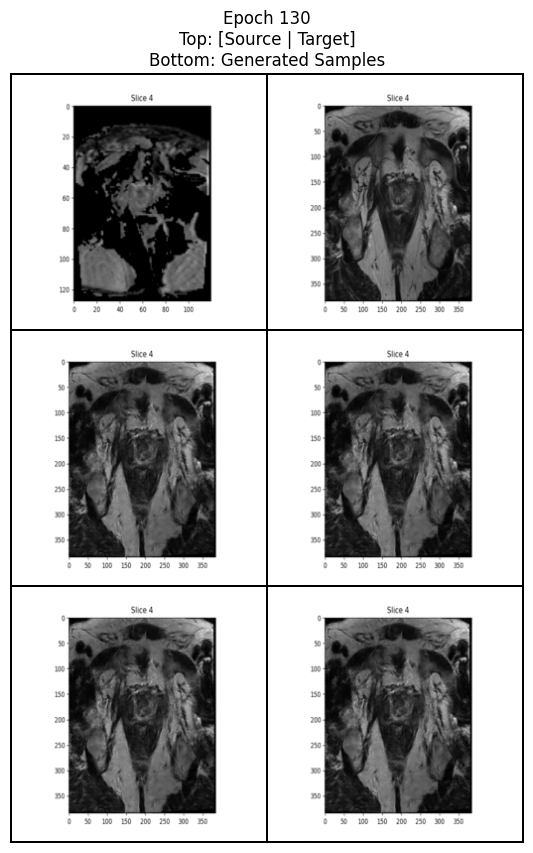

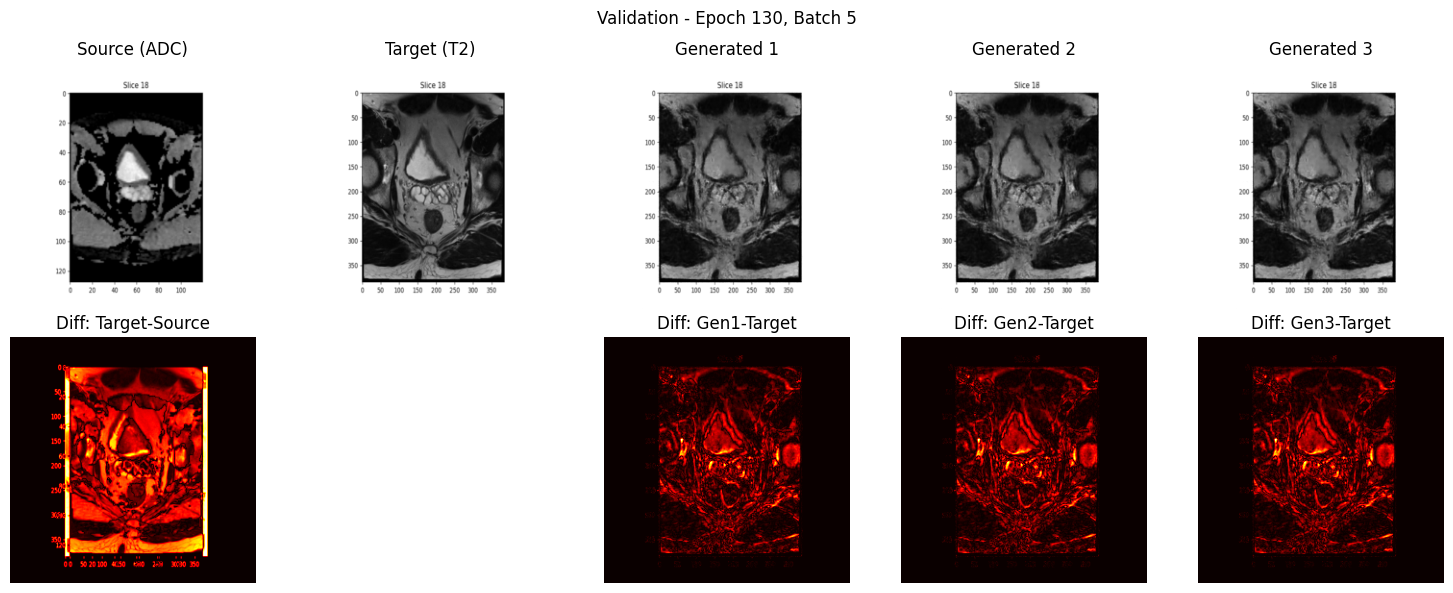

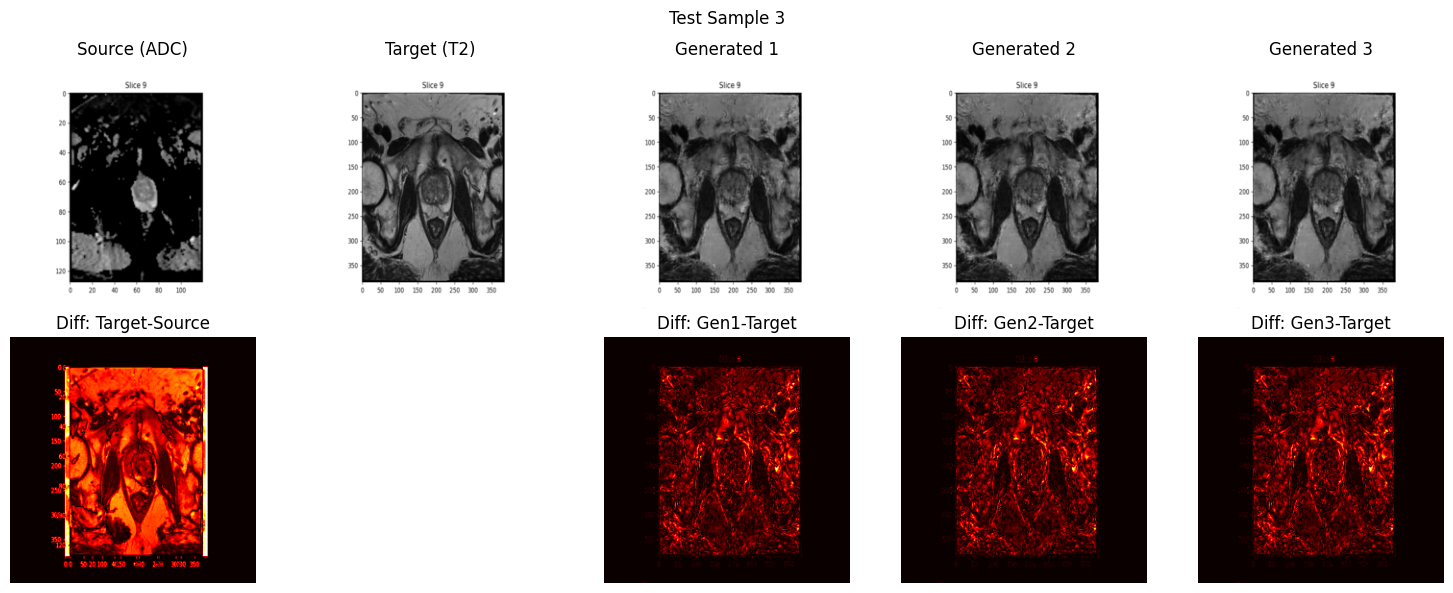

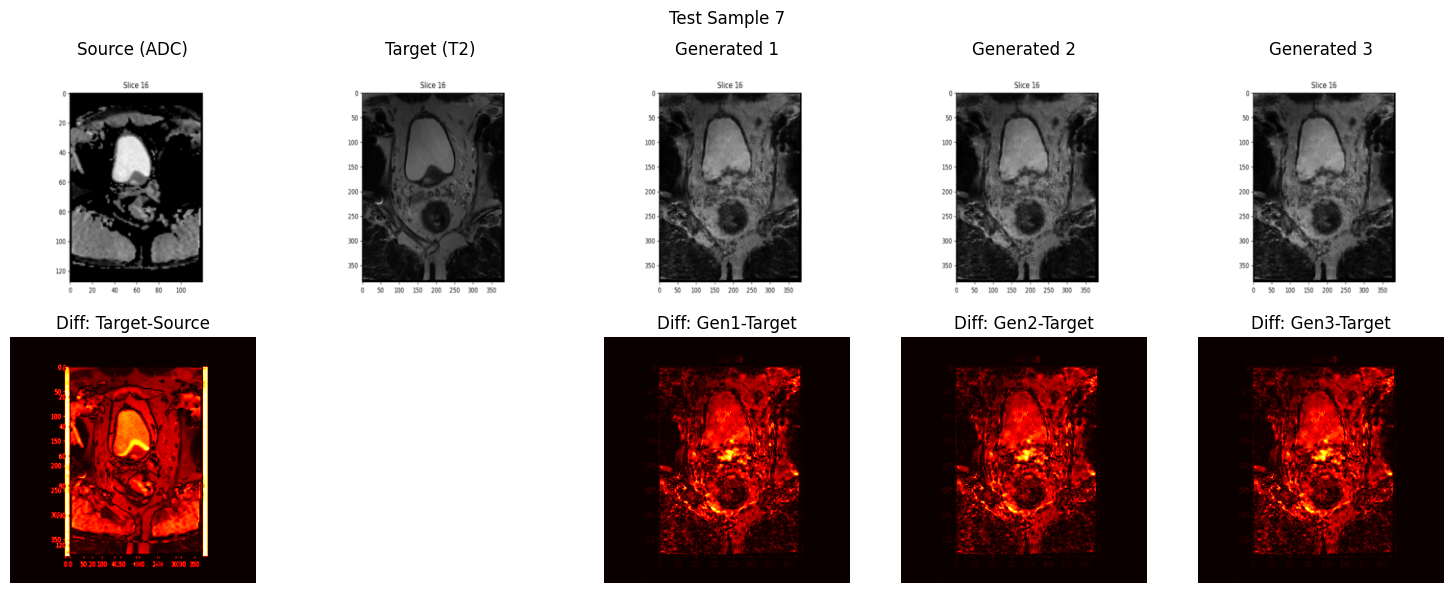

Test Metrics - Epoch 130:
PSNR: 25.4267
SSIM: 0.7931
L1: 0.0513
Early stopping triggered BUT CONTINUING
Epoch [131/300] Batch [0/119] G_loss: 8.8660 D_loss: 0.3316  LRs: {'lr_G': 0.00013421772800000008, 'lr_E': 0.00013421772800000008, 'lr_D': 0.00013421772800000008}
Test Metrics - Epoch 131:
PSNR: 25.4086
SSIM: 0.7931
L1: 0.0515
Early stopping triggered BUT CONTINUING
Epoch [132/300] Batch [0/119] G_loss: 8.1135 D_loss: 0.2796  LRs: {'lr_G': 0.00013421772800000008, 'lr_E': 0.00013421772800000008, 'lr_D': 0.00013421772800000008}
Test Metrics - Epoch 132:
PSNR: 25.4128
SSIM: 0.7929
L1: 0.0514
Early stopping triggered BUT CONTINUING
Epoch [133/300] Batch [0/119] G_loss: 9.0981 D_loss: 0.2711  LRs: {'lr_G': 0.00013421772800000008, 'lr_E': 0.00013421772800000008, 'lr_D': 0.00013421772800000008}
Test Metrics - Epoch 133:
PSNR: 25.4159
SSIM: 0.7929
L1: 0.0513
Early stopping triggered BUT CONTINUING
Epoch [134/300] Batch [0/119] G_loss: 7.6703 D_loss: 0.2364  LRs: {'lr_G': 0.000134217728000000

KeyboardInterrupt: 

In [64]:
losses, val_losses = train(model, train_loader, val_loader, test_loader,
                         num_epochs=config['epochs'], save_path=save_path)

In [ ]:
# Plot training losses
# plt.figure(figsize=(10, 5))
# plt.plot([d['G_loss'] for d in losses_history], label='Generator')
# plt.plot([d['D_loss'] for d in losses_history], label='Discriminator')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training Losses')
# plt.show()

In [ ]:
# https://colab.research.google.com/drive/1k_GAfXpoVVr20G-UPbC90SYt4MoErZsC#gceVm=ftcdl-439312/us-central1-b/colab-1-vm